<a href="https://www.kaggle.com/code/mmellinger66/ps3e11-eda-xgb-lgbm-cat?scriptVersionId=124494351" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color:rgba(255,114,118, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Playground Season 3: Episode 11 - EDA</h1>
</div>

This kernel will focus on Exploratory Data Analysis.


## Problem Type

Regression

## Evaluation Metric

RMSLE

$$MSLE(y,\hat{y}) = \frac{1}{n_{samples}} \sum_{i=0}^{n_{samples-1}} log_e (1 + y_i) - log_e(1+\hat{y}_i))^2$$

```python
fold_score = metrics.mean_squared_log_error(yvalid, preds_valid, squared=False)
```



<div style="background-color:rgba(255,114,118, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [1]:
from typing import List, Set, Dict, Tuple, Optional

import os
import time
from pathlib import Path
import glob
import gc

import pandas as pd
import numpy as np

from sklearn import impute
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import cluster
from sklearn import model_selection
from sklearn import ensemble
from sklearn import decomposition
from sklearn import datasets


import xgboost as xgb
import catboost as cb
import lightgbm as lgb


from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
from folium import Map
from folium.plugins import HeatMap
from IPython.display import display_html, display_markdown, display_latex
from colorama import Fore, Style

import warnings
warnings.filterwarnings('ignore')

import pandas_profiling


<div style="background-color:rgba(255,114,118, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [2]:
TARGET="cost"

In [3]:
class Config:
    path:str = "../input/playground-series-s3e11/"
    gpu:bool = False
    optimize:bool = False
    n_optuna_trials:int = 10
    fast_render:bool = False
    calc_probability:bool = False # When doing classication, we might want probabilities
    debug:bool = False
    seed:int = 42
    N_ESTIMATORS:int = 1000  # 100, 300, 1000, 2000, 5000, 15_000, 20_000 GBDT
    GPU_N_ESTIMATORS:int = 1000 # Want models to run fast during dev
    N_FOLDS:int = 15

<div class="alert alert-block alert-info">
<b>Tip:</b> Attemping to move as much into the Config class as possible
</div>

<div style="background-color:rgba(255,114,118, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Theme</h1>
</div>

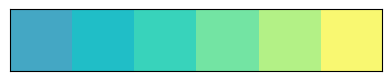

In [4]:
mpl.rcParams["font.size"] = 16

theme_colors = ["#44A7C4", "#20BEC7", "#38D3BB", "#73E4A3", "#B3F186", "#F9F871"]
theme_palette = sns.set_palette(sns.color_palette(theme_colors))

sns.palplot(sns.color_palette(theme_colors), size=0.8)
plt.tick_params(axis="both", labelsize=0, length=0)

plt.style.use('ggplot') # 'fivethirtyeight'

pd.options.display.float_format = '{:,.2f}'.format

In [5]:
class clr:
    S = Style.BRIGHT + Fore.LIGHTRED_EX
    E = Style.RESET_ALL

<div style="background-color:rgba(255,114,118, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Creating a few functions that will be reused in each project.

I need to be better with [DRY](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) on Kaggle.

In [6]:
def read_data(path: str, analyze:bool=True) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    if analyze:
        print(clr.S + "=== Shape of Data ==="+clr.E)
        print(f" train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
        print(f" test data : Rows={test.shape[0]}, Columns={test.shape[1]}")

        print(clr.S + "\n=== Train Data: First 5 Rows ===\n"+clr.E)
        display(train.head())
        print(f"\n{clr.S}=== Train Column Names ==={clr.E}\n")
        display(train.columns)
        print(f"\n{clr.S}=== Features/Explanatory Variables ==={clr.E}\n")
        eval_features(train)
        print(f"\n{clr.S}=== Skewness ==={clr.E}\n")
        check_skew(train)
    return train, test, submission_df

def create_submission(model_name: str, target, preds, seed:int=42, nfolds:int=5) -> pd.DataFrame:
    sample_submission[target] = preds

    if len(model_name) > 0:
        fname = f"submission_{model_name}_k{nfolds}_s{seed}.csv"
    else:
        fname = "submission.csv"

    sample_submission.to_csv(fname, index=False)

    return sample_submission

def show_classification_scores(ground_truth:List[int], yhat:List[int]) -> None:
    accuracy = metrics.accuracy_score(ground_truth, yhat)
    precision = metrics.precision_score(ground_truth, yhat)
    recall = metrics.recall_score(ground_truth, yhat)
    roc = metrics.roc_auc_score(ground_truth, yhat)
    f1 = metrics.f1_score(ground_truth, yhat)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC: {roc:.4f}")
    print(f"f1: {f1:.4f}")
    

def label_encoder(train:pd.DataFrame, test:pd.DataFrame, columns:List[str]) -> (pd.DataFrame, pd.DataFrame) :
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = preprocessing.LabelEncoder().fit_transform(train[col])
        test[col] = preprocessing.LabelEncoder().fit_transform(test[col])
    return train, test   

def create_strat_folds(df:pd.DataFrame, TARGET, n_folds:int=5, seed:int=42) -> pd.DataFrame:
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = model_selection.StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df


def create_folds(df:pd.DataFrame, n_folds:int=5, seed:int=42) -> pd.DataFrame:
    print(f"n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df)):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

def show_fold_scores(scores: List[float]) -> (float, float):
    cv_score = np.mean(scores)  # Used in filename
    std_dev = np.std(scores)
    print(
        f"Scores -> Adjusted: {np.mean(scores) - np.std(scores):.8f} , mean: {np.mean(scores):.8f}, std: {np.std(scores):.8f}"
    )
    return cv_score, std_dev


def feature_distribution_types(df:pd.DataFrame, display:bool=True) -> (List[str], List[str]):
    continuous_features = list(df.select_dtypes(include=['int64', 'float64', 'uint8']).columns)
    categorical_features = list(df.select_dtypes(include=['object', 'bool']).columns)
    if display:
        print(f"{clr.S}Continuous Features={continuous_features}{clr.E}\n")
        print(f"{clr.S}Categorical Features={categorical_features}{clr.E}")
    return continuous_features, categorical_features   

def show_cardinality(df:pd.DataFrame, features:List[str]) -> None:
    print("=== Cardinality ===")
    print(df[features].nunique())

## === Model Support ===    

from scipy.stats import mode


def merge_test_predictions(final_test_predictions:List[float], calc_probability:bool=True) -> List[float]:

    if Config.calc_probability:
        print("Mean")
        result = np.mean(np.column_stack(final_test_predictions), axis=1)
    else:
        print("Mode")
        mode_result = mode(np.column_stack(final_test_predictions), axis=1)
        result = mode_result[0].ravel()

    return result

def summary_statistics(X:pd.DataFrame, enhanced=True) -> None:
    desc = X.describe()
    if enhanced:
        desc.loc["var"] = X.var(numeric_only=True).tolist()
        desc.loc["skew"] = X.skew(numeric_only=True).tolist()
        desc.loc["kurt"] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context("display.precision", 2):
        style = desc.transpose().style.background_gradient(
            cmap="coolwarm"
        )  # .set_precision(4)
    display(style)
    
def show_missing_features(df:pd.DataFrame) -> None:
    missing_vals = df.isna().sum().sort_values(ascending=False)
    print(missing_vals[missing_vals > 0])


def show_duplicate_records(df:pd.DataFrame) -> None:
    dups = df.duplicated()
    print(dups.sum())


def eval_features(df:pd.DataFrame) -> (List[str], List[str], List[str]):
    ## Separate Categorical and Numerical Features
    categorical_features = list(
        df.select_dtypes(include=["category", "object"]).columns
    )
    continuous_features = list(df.select_dtypes(include=["number"]).columns)

    print(f"{clr.S}Continuous features:{clr.E} {continuous_features}")
    print(f"{clr.S}Categorical features:{clr.E} {categorical_features}")
    print("\n --- Cardinality of Categorical Features ---\n")

    for feature in categorical_features:
        cardinality = df[feature].nunique()
        if cardinality < 10:
            print(f"{clr.S}{feature}{clr.E}: cardinality={cardinality}, {df[feature].unique()}")
        else:
            print(f"{clr.S}{feature}{clr.E}: cardinality={cardinality}")
    all_features = categorical_features + continuous_features
    return all_features, categorical_features, continuous_features


def show_feature_importance(feature_importance_lst:List[str]) -> None:
    fis_df = pd.concat(feature_importance_lst, axis=1)

    fis_df.sort_values("0_importance", ascending=True).head(40).plot(
        kind="barh", figsize=(12, 12), title="Feature Importance Across Folds"
    )
    plt.show()


def show_feature_target_crosstab(df:pd.DataFrame, feature_lst:List[str], target:str) -> None:
    for feature in feature_lst:
        print(f"\n=== {feature} vs {target} ===\n")
        display(
            pd.crosstab(df[feature], df[target], margins=True)
        )  # display keeps bold formatting


def show_cardinality(df:pd.DataFrame, features:List[str]) -> None:
    print(f"{clr.S}=== Cardinality ==={clr.E}")
    print(df[features].nunique())


def show_unique_features(df:pd.DataFrame, features:List[str]) -> None:
    for col in features:
        print(col, sorted(df[col].dropna().unique()))


def feature_distribution_types(df:pd.DataFrame, display:bool=True) -> (List[str], List[str]):
    continuous_features = list(
        df.select_dtypes(include=["int64", "float64", "uint8"]).columns
    )
    categorical_features = list(df.select_dtypes(include=["object", "bool"]).columns)
    if display:
        print(f"{clr.S}Continuous Features={clr.E}{continuous_features}\n")
        print(f"{clr.S}Categorical Features={clr.E}{categorical_features}")
    return continuous_features, categorical_features


def describe(X:pd.DataFrame) -> None:
    "Deprecated: Use summary_statistics()"
    desc = X.describe()
    desc.loc['var'] = X.var(numeric_only=True).tolist()
    desc.loc['skew'] = X.skew(numeric_only=True).tolist()
    desc.loc['kurt'] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context('display.precision', 2):
        style = desc.transpose().style.background_gradient(cmap='coolwarm') #.set_precision(4)
    display(style)
  

def check_skew(df:pd.DataFrame) -> None:
    skew = df.skew(skipna=True,numeric_only=True).sort_values(ascending=False)
    print(skew)
    
def gpu_ify_lgbm(lgbm_dict):
    lgbm_dict["device"] = "gpu"
    lgbm_dict["boosting_type"] = "gbdt"
    lgbm_dict["gpu_platform_id"] = 0
    lgbm_dict["gpu_device_id"] = 0
    return lgbm_dict

def gpu_ify_cb(params):
    params["task_type"] = "GPU"
    return params    


<div style="background-color:rgba(255,114,118, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data and Analyze</h1>
</div>

## Load the following files

 - train.csv - Data used to build our machine learning model
 - test.csv - Data used to build our machine learning model. Does not contain the target variable
 - sample_submission.csv - A file in the proper format to submit test predictions

In [7]:
%%time
train, test, sample_submission = read_data(Config.path, analyze=True)

=== Shape of Data ===
 train data: Rows=360336, Columns=17
 test data : Rows=240224, Columns=16

=== Train Data: First 5 Rows ===



,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.00,2.00,2.00,2.00,10.30,1.00,0.00,32.00,"36,509.00",0.00,0.00,0.00,0.00,0.00,62.09
1,1,5.00,2.00,4.00,0.00,3.00,6.66,1.00,0.00,1.00,"28,206.00",1.00,0.00,0.00,0.00,0.00,121.80
2,2,14.08,4.00,0.00,0.00,3.00,21.30,1.00,0.00,26.00,"21,215.00",1.00,0.00,0.00,0.00,0.00,83.51
3,3,4.02,3.00,5.00,0.00,0.00,14.80,0.00,1.00,36.00,"21,215.00",1.00,0.00,0.00,0.00,0.00,66.78
4,4,2.13,3.00,5.00,0.00,3.00,17.00,1.00,1.00,20.00,"27,694.00",1.00,1.00,1.00,1.00,1.00,111.51



=== Train Column Names ===



Index(['id', 'store_sales(in millions)', 'unit_sales(in millions)',
       'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1',
       'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case',
       'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food',
       'florist', 'cost'],
      dtype='object')


=== Features/Explanatory Variables ===

Continuous features: ['id', 'store_sales(in millions)', 'unit_sales(in millions)', 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist', 'cost']
Categorical features: []

 --- Cardinality of Categorical Features ---


=== Skewness ===

num_children_at_home          1.85
video_store                   0.99
low_fat                       0.73
store_sales(in millions)      0.66
store_sqft                    0.39
gross_weight                  0.09
total_children                0.04
cost                          0.02
id                           -0.00
florist                      -0.01
salad_bar                    -0.02
prepared_food                -0.02
avg_cars_at home(approx).1   -0.07
units_per_case               -0.10
unit_sales(in millions)      -0.11
coffee_bar                   

In [8]:
# %%time

# train = add_features(train)    
# test = add_features(test)

In [9]:
train.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.00,2.00,2.00,2.00,10.30,1.00,0.00,32.00,"36,509.00",0.00,0.00,0.00,0.00,0.00,62.09
1,1,5.00,2.00,4.00,0.00,3.00,6.66,1.00,0.00,1.00,"28,206.00",1.00,0.00,0.00,0.00,0.00,121.80
2,2,14.08,4.00,0.00,0.00,3.00,21.30,1.00,0.00,26.00,"21,215.00",1.00,0.00,0.00,0.00,0.00,83.51
3,3,4.02,3.00,5.00,0.00,0.00,14.80,0.00,1.00,36.00,"21,215.00",1.00,0.00,0.00,0.00,0.00,66.78
4,4,2.13,3.00,5.00,0.00,3.00,17.00,1.00,1.00,20.00,"27,694.00",1.00,1.00,1.00,1.00,1.00,111.51


### Pandas Profiling

In [10]:
# train.profile_report()

## Categorical/Numerical Variables

In [11]:
cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

cont_features.remove(TARGET)
cont_features.remove("id")
FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['id', 'store_sales(in millions)', 'unit_sales(in millions)', 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist', 'cost']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['store_sales(in millions)',
 'unit_sales(in millions)',
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'gross_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist']

### Identify Numerical/Continuous that are Potentially Categorical

StandardHours, Over18, and EmployeeCount have only 1 value.  Should remove them.

In [12]:
sub25 = train.nunique()[train.nunique() < 25][:-1]
sub25

unit_sales(in millions)        6
total_children                 6
num_children_at_home           6
avg_cars_at home(approx).1     5
recyclable_package             2
low_fat                        2
store_sqft                    20
coffee_bar                     2
video_store                    2
salad_bar                      2
prepared_food                  2
dtype: int64

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [14]:
summary_statistics(train.drop(columns=["id"], axis=1), enhanced=True) # var,skew,kurtosis

,count,mean,std,min,25%,50%,75%,max,var,skew,kurt
store_sales(in millions),360336.00,6.34,3.31,0.51,3.72,5.78,8.40,22.92,10.94,0.66,0.08
unit_sales(in millions),360336.00,3.04,0.78,1.00,3.00,3.00,4.00,6.00,0.62,-0.11,-0.25
total_children,360336.00,2.46,1.49,0.00,1.00,2.00,4.00,5.00,2.22,0.04,-1.04
num_children_at_home,360336.00,0.69,1.21,0.00,0.00,0.00,1.00,5.00,1.48,1.85,2.60
avg_cars_at home(approx).1,360336.00,2.20,1.08,0.00,1.00,2.00,3.00,4.00,1.18,-0.07,-0.76
gross_weight,360336.00,13.82,4.61,6.00,9.71,13.60,17.70,21.90,21.30,0.09,-1.23
recyclable_package,360336.00,0.57,0.50,0.00,0.00,1.00,1.00,1.00,0.25,-0.27,-1.92
low_fat,360336.00,0.33,0.47,0.00,0.00,0.00,1.00,1.00,0.22,0.73,-1.46
units_per_case,360336.00,18.97,10.21,1.00,10.00,20.00,28.00,36.00,104.30,-0.10,-1.24
store_sqft,360336.00,28180.33,5968.87,20319.00,23593.00,27694.00,33858.00,39696.00,35627457.71,0.39,-1.07


### Continuous Distributions

15 Continous Features


<Figure size 640x480 with 0 Axes>

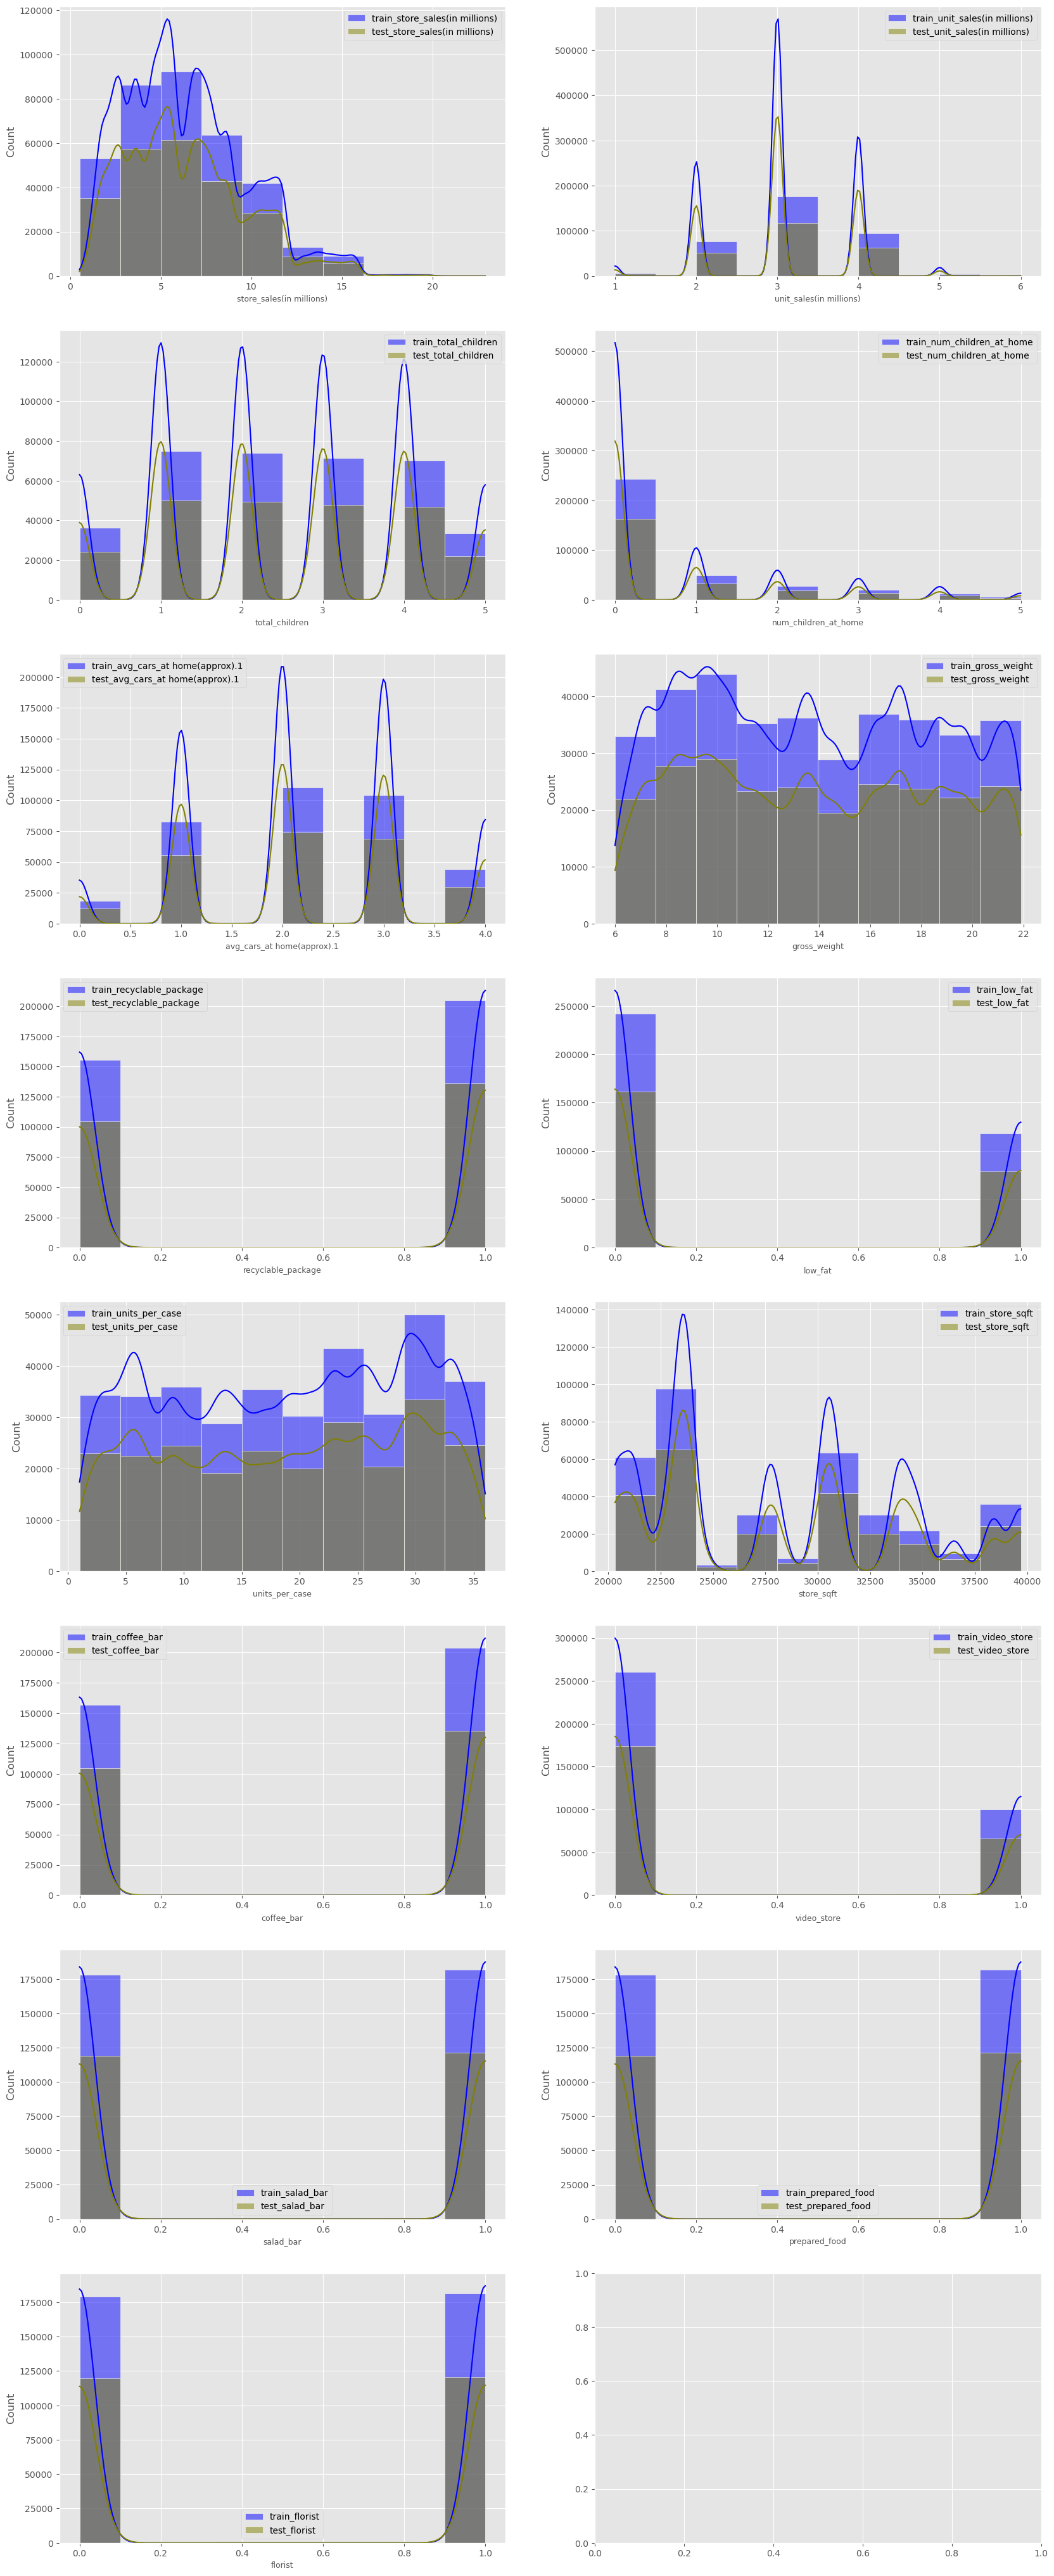

CPU times: user 43.9 s, sys: 8.39 s, total: 52.3 s
Wall time: 39.8 s


In [15]:
%%time

def plot_continuous_features(train:pd.DataFrame, test:pd.DataFrame, continuous_features:List[str], nrows:int, ncols:int):
    plt.figure()
    n_features = len(continuous_features)
    fig, ax = plt.subplots(8, 2, figsize=(20, 52))
    print(f"{n_features} Continous Features")
    for i, feature in enumerate(continuous_features):
#         print(f"Feature: {feature}")
        plt.subplot(nrows, ncols, i + 1)
        sns.histplot(
            x=feature, color="blue", kde=True, bins=10, label="train_" + feature, data=train
        )
        sns.histplot(
            x=feature, color="olive", kde=True, bins=10, label="test_" + feature, data=test
        )
        plt.xlabel(feature, fontsize=9)
        plt.legend()
    plt.show()
    
plot_continuous_features(train,test,cont_features,8,2)

### Categorical Distributions

In [16]:
# plt.figure()
# fig, ax = plt.subplots(4, 2, figsize=(15, 15))

# n_features = len(cat_features)
# print(f"{n_features} Categorical Features")

# categorical_features = cat_features # 
# for i, feature in enumerate(categorical_features):
#     print(f"Feature: {feature}")
#     plt.subplot(4, 2, i + 1)
#     sns.countplot(
#         x=feature, label="train_" + feature, data=train
#     )
# plt.show()

### Look for Outliers in Continuous Features

--- store_sales(in millions) ---


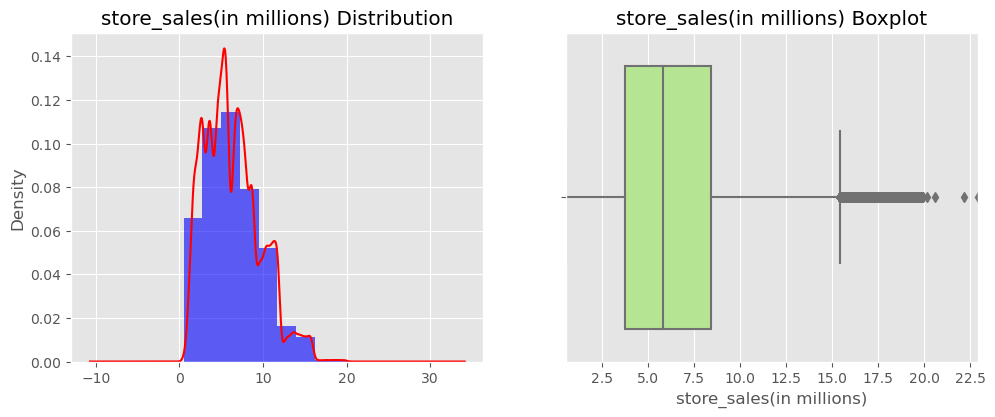

--- unit_sales(in millions) ---


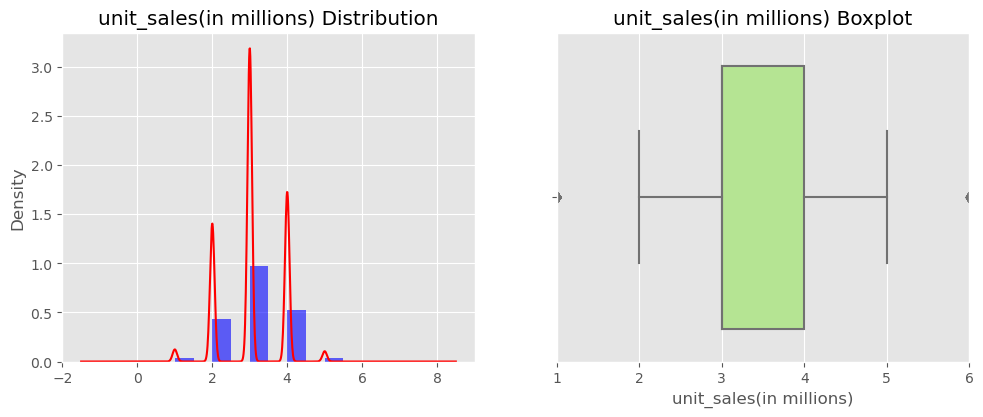

--- total_children ---


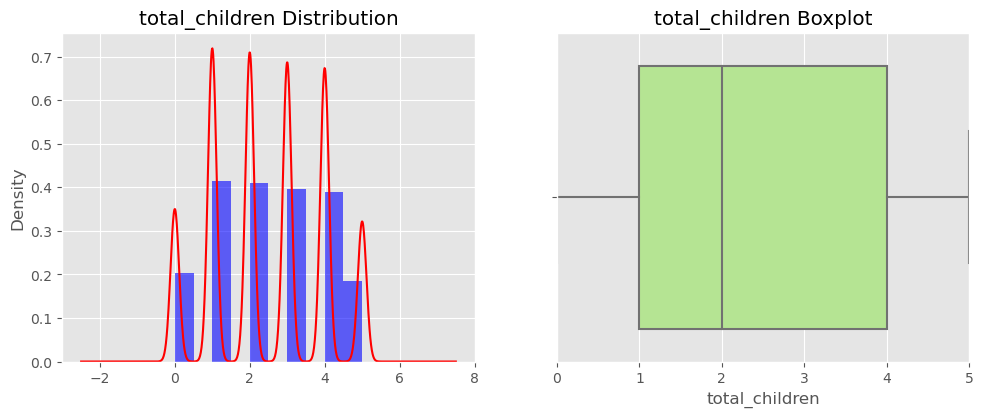

--- num_children_at_home ---


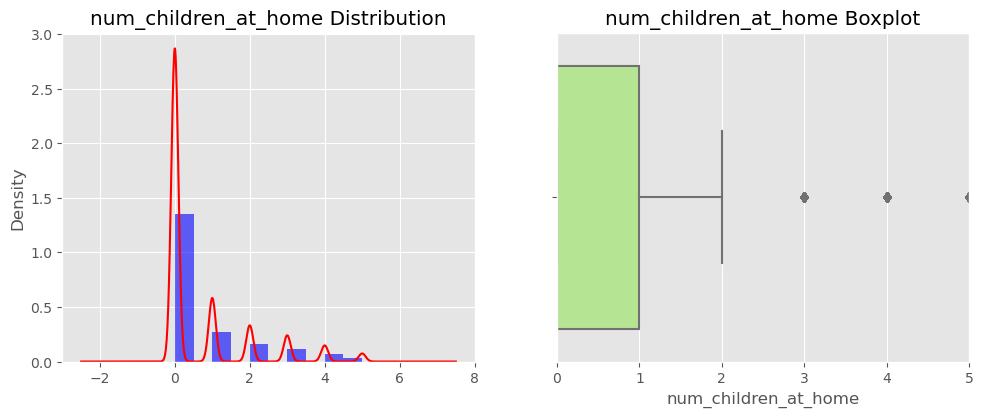

--- avg_cars_at home(approx).1 ---


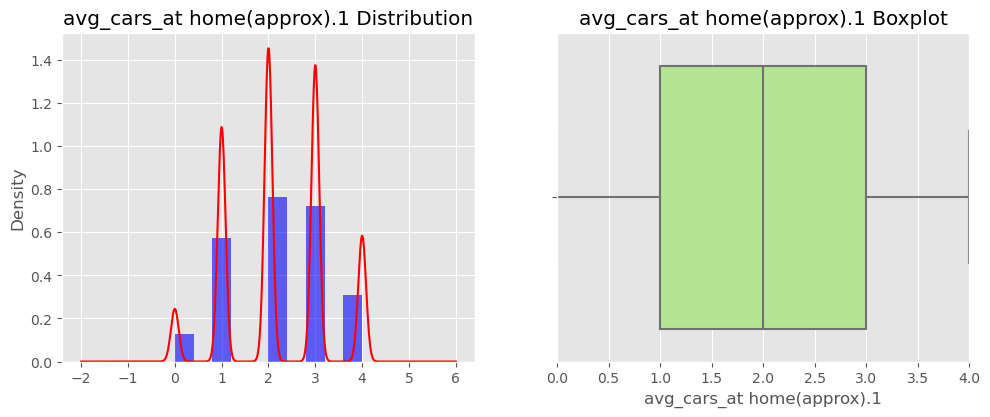

--- gross_weight ---


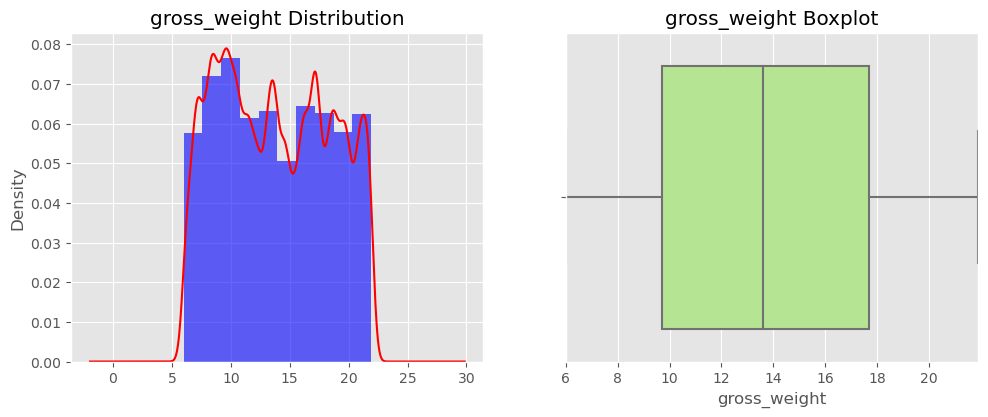

--- recyclable_package ---


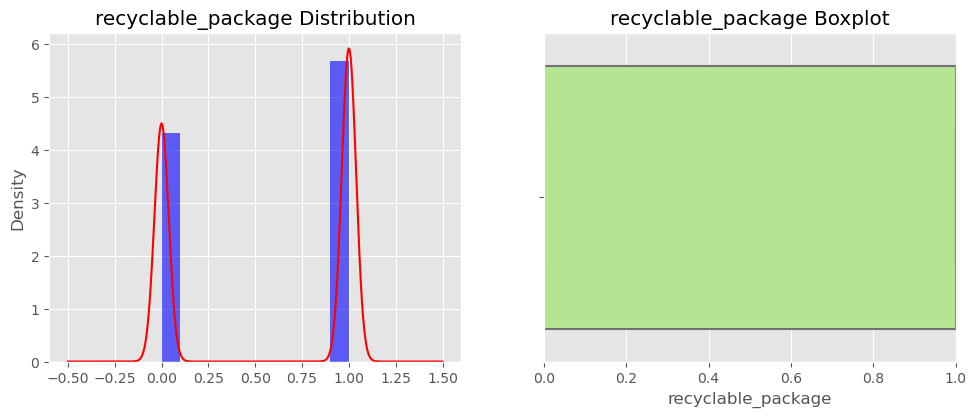

--- low_fat ---


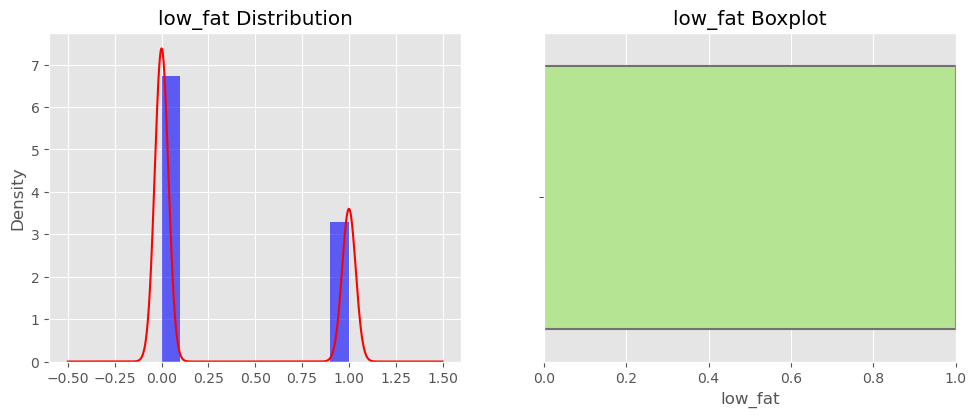

--- units_per_case ---


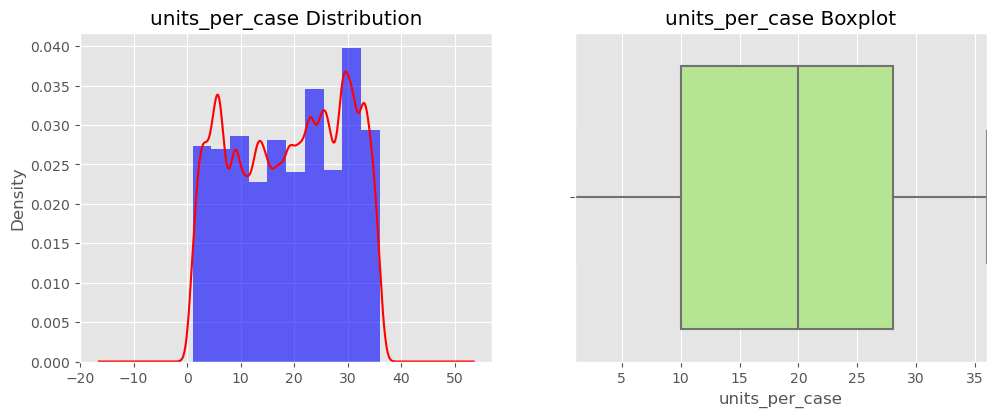

--- store_sqft ---


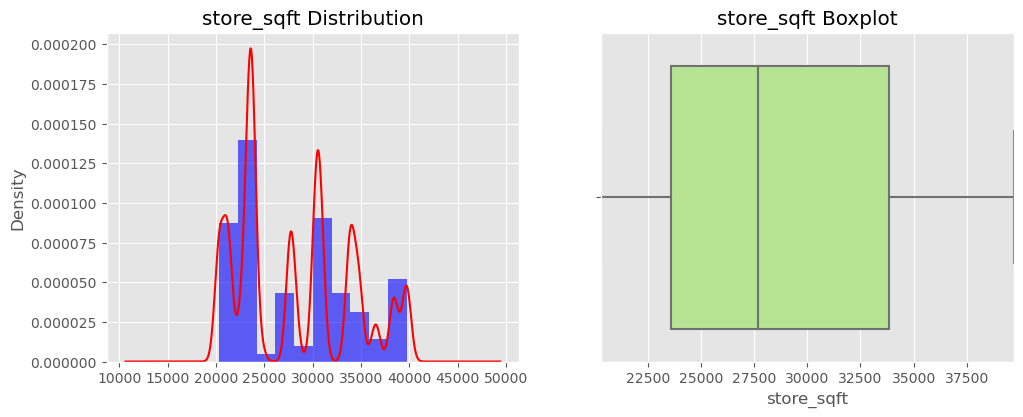

--- coffee_bar ---


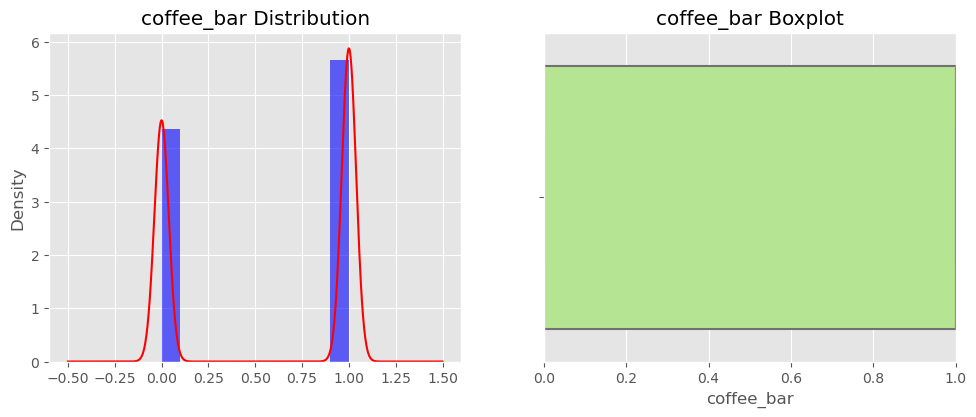

--- video_store ---


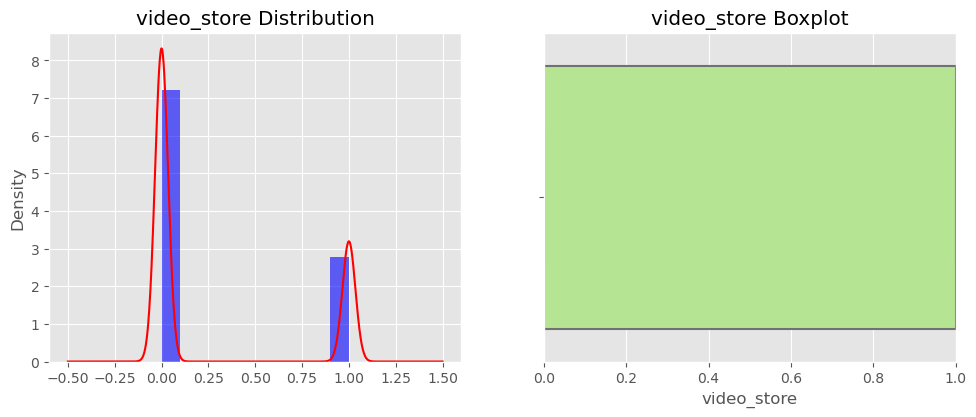

--- salad_bar ---


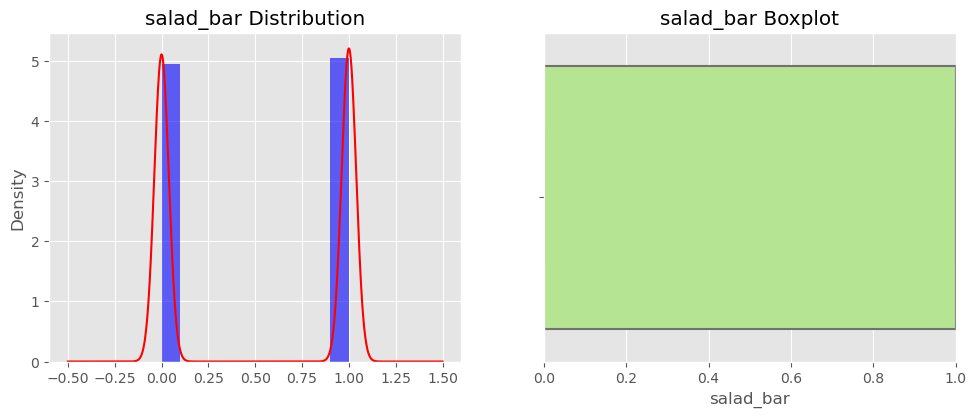

--- prepared_food ---


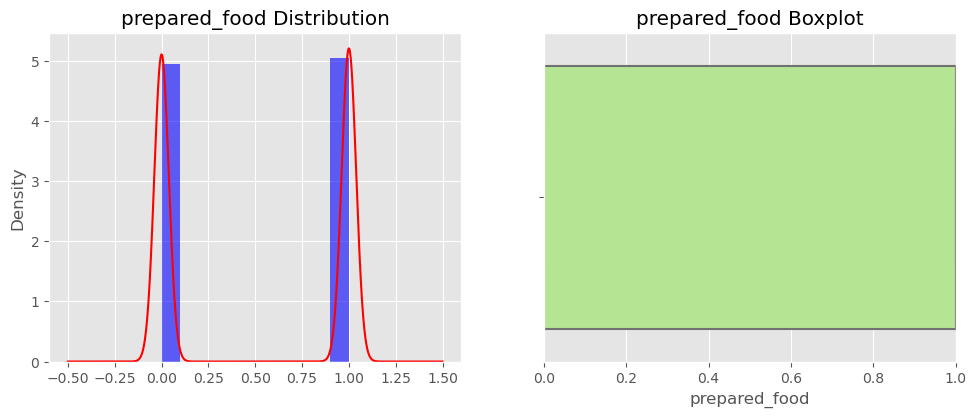

--- florist ---


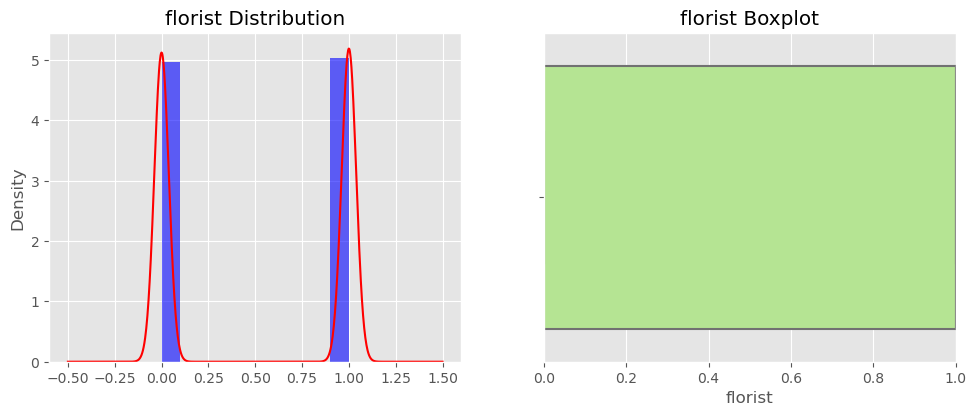

In [17]:
def plot_hist_bloxplot(df:pd.DataFrame, feature:str) -> None:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

#     plt.figure(figsize=(6,4))
    fig.set_size_inches(10, 14)

    ax = df[feature].hist(
        bins=10,
        density=True,
        stacked=True,
        color="blue",
        alpha=0.6,
        ax=axs[0],
        figsize=(6,4)

    )
    df[feature].plot(
        kind="density",
        color="red",
        title=f"{feature} Distribution",
        ax=axs[0]
    )

    min = df[feature].min()
    max = df[feature].max()
    plt.xlim(min, max)

    # plt.figure(figsize=(12,4))
    fig.set_size_inches(11.7, 4.27)
    sns.boxplot(data=df, 
                x=feature,
                color=theme_colors[4],
                ax=axs[1],
    #             figsize=(12,4)
               )
    axs[1].set_title(f'{feature} Boxplot')
    plt.show()

cont_features2 = [feature for feature in cont_features if feature not in ["EmployeeCount", "Over18"]]

for feature in cont_features2:
    print(f"--- {feature} ---")
    plot_hist_bloxplot(train, feature)   

In [18]:
corr_matrix = train.corr()[[TARGET]].sort_values(by = [TARGET], ascending = False).drop([TARGET]).T
# with pd.option_context('display.precision', 2):
#     style = corr_matrix.transpose().style.background_gradient(cmap='coolwarm')
# display(style)
corr_matrix.style.background_gradient(cmap = 'coolwarm').set_precision(4)

,avg_cars_at home(approx).1,units_per_case,gross_weight,id,recyclable_package,num_children_at_home,low_fat,total_children,store_sales(in millions),unit_sales(in millions),store_sqft,coffee_bar,salad_bar,prepared_food,video_store,florist
cost,0.0271,0.0002,-0.0001,-0.0006,-0.0015,-0.0017,-0.0020,-0.0075,-0.0124,-0.0265,-0.0492,-0.0521,-0.0988,-0.0988,-0.1068,-0.1104


### Correlation Heatmap

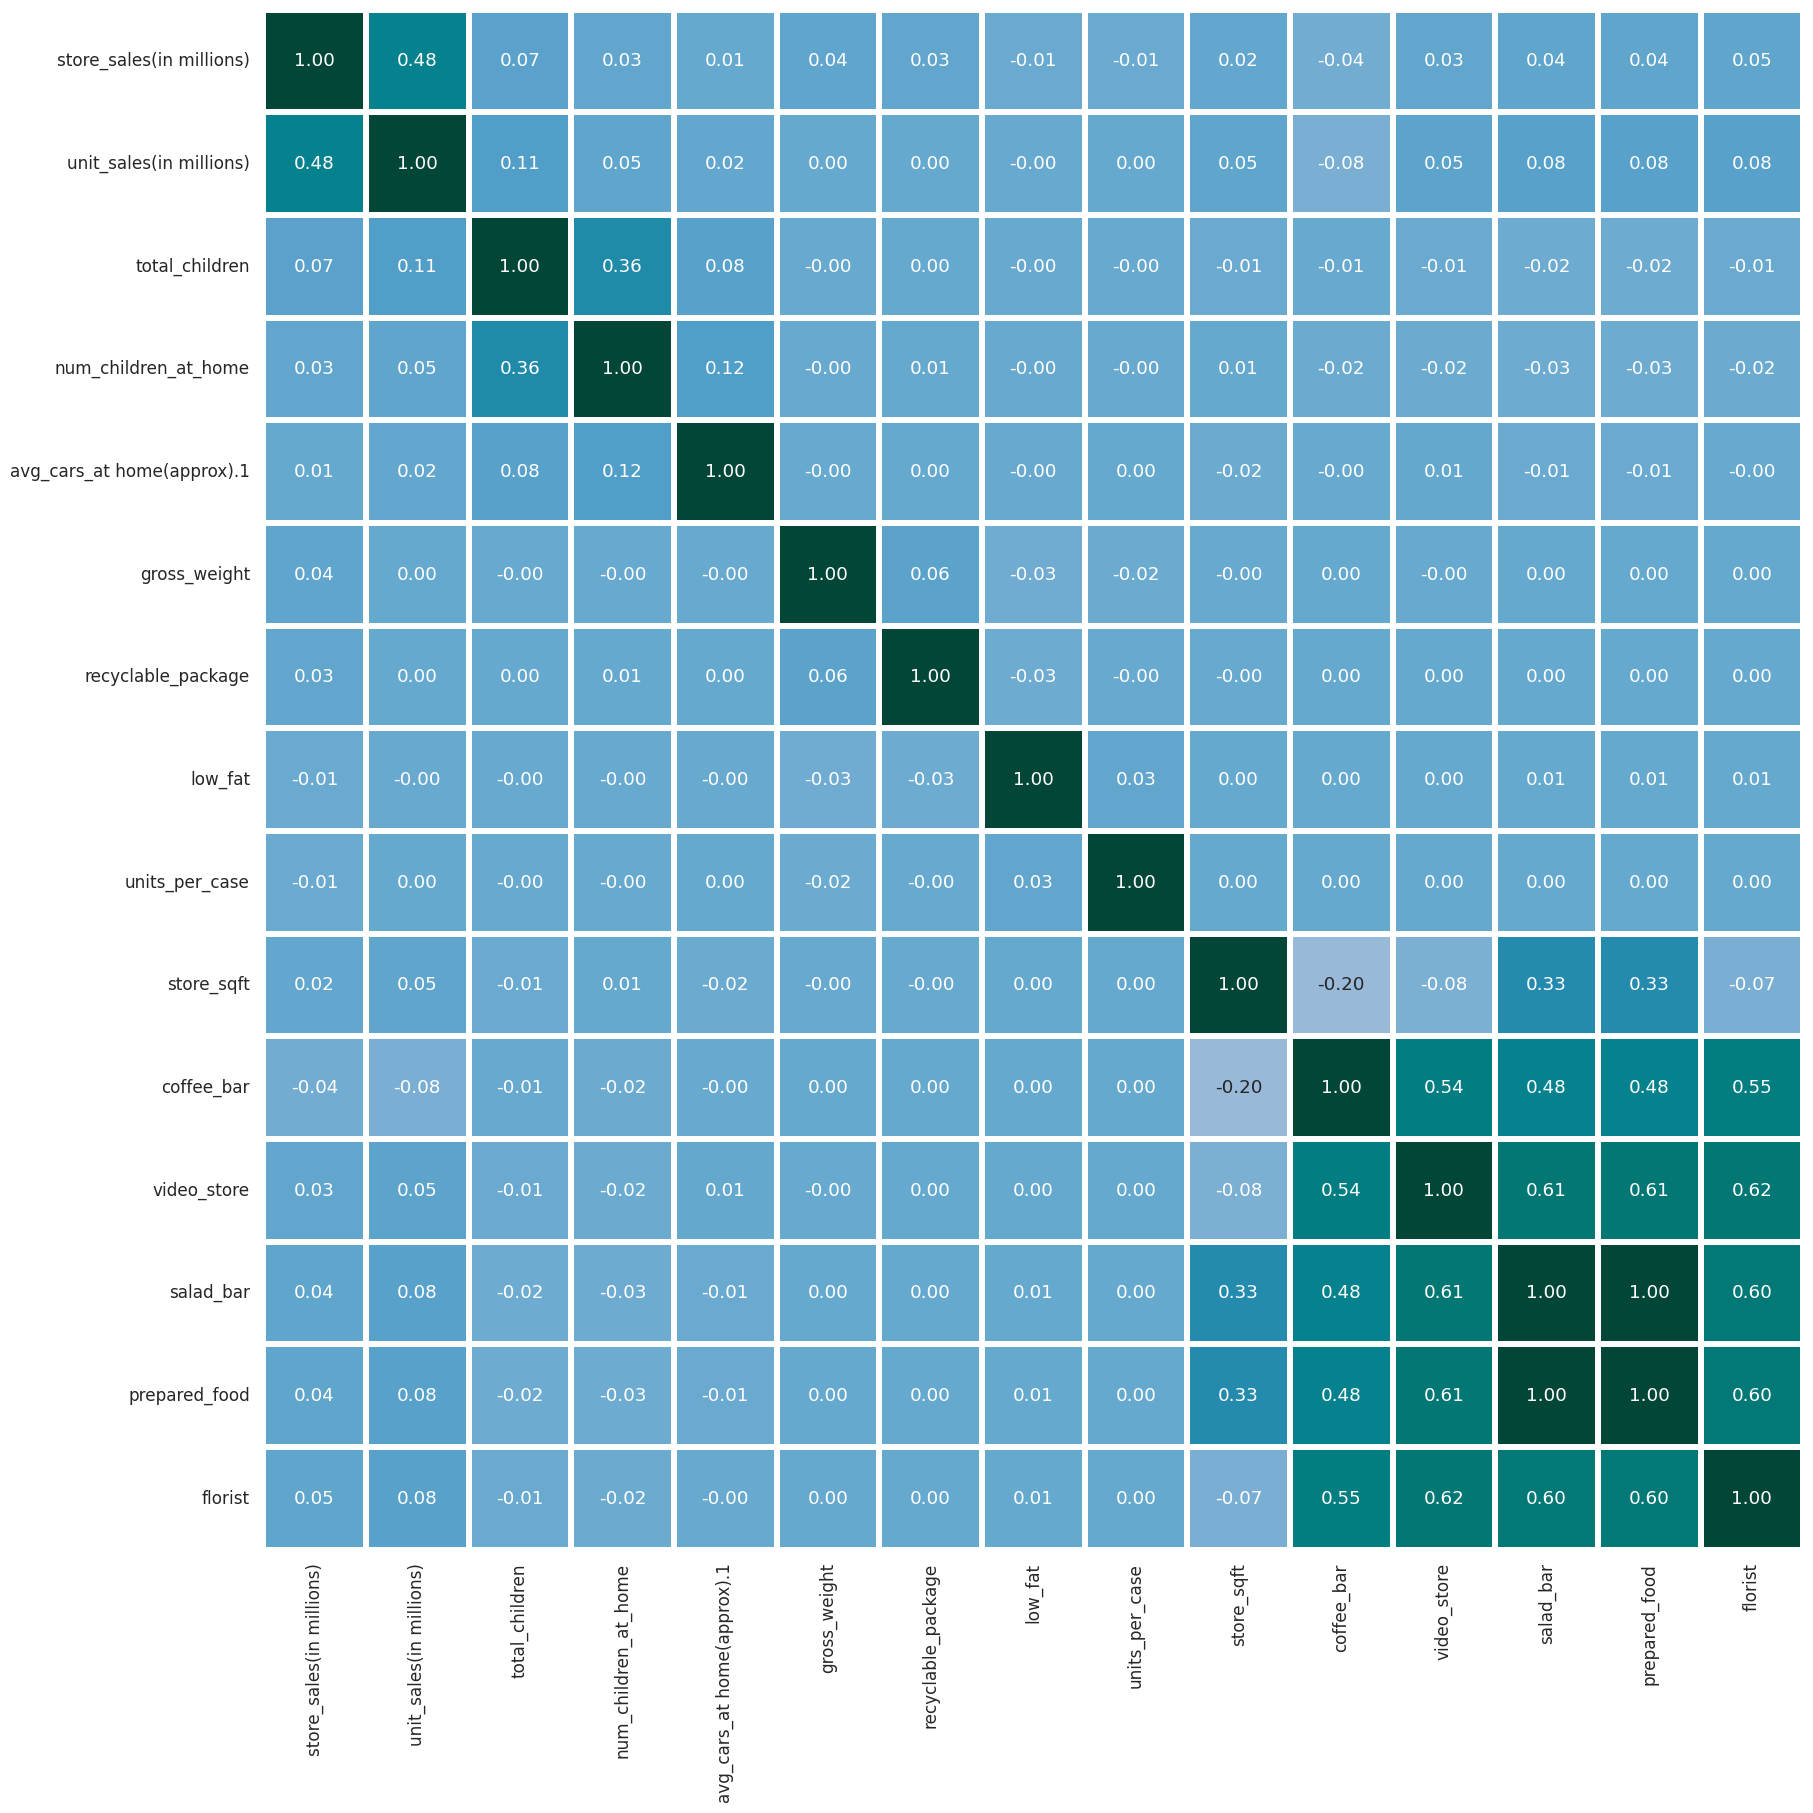

CPU times: user 2.06 s, sys: 274 ms, total: 2.33 s
Wall time: 2.1 s


In [19]:
%%time

corr = train[cont_features].corr()
mask = np.triu(train[cont_features].corr())

sns.set(font_scale=1.1)
# plt.figure(figsize=(8, 8), dpi=240)
f,ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, 
            annot=True, 
            fmt='.2f', 
            cmap='PuBuGn', # ('PuBuGn', 'coolwarm', 'seismic')
            square=True, 
#             mask=mask, 
            linewidths=4,
            cbar=False,  # Show color bar at right
            cbar_kws={"shrink": .7},
            vmin = -1,
            vmax = 1,
            ax=ax
           )
plt.show()

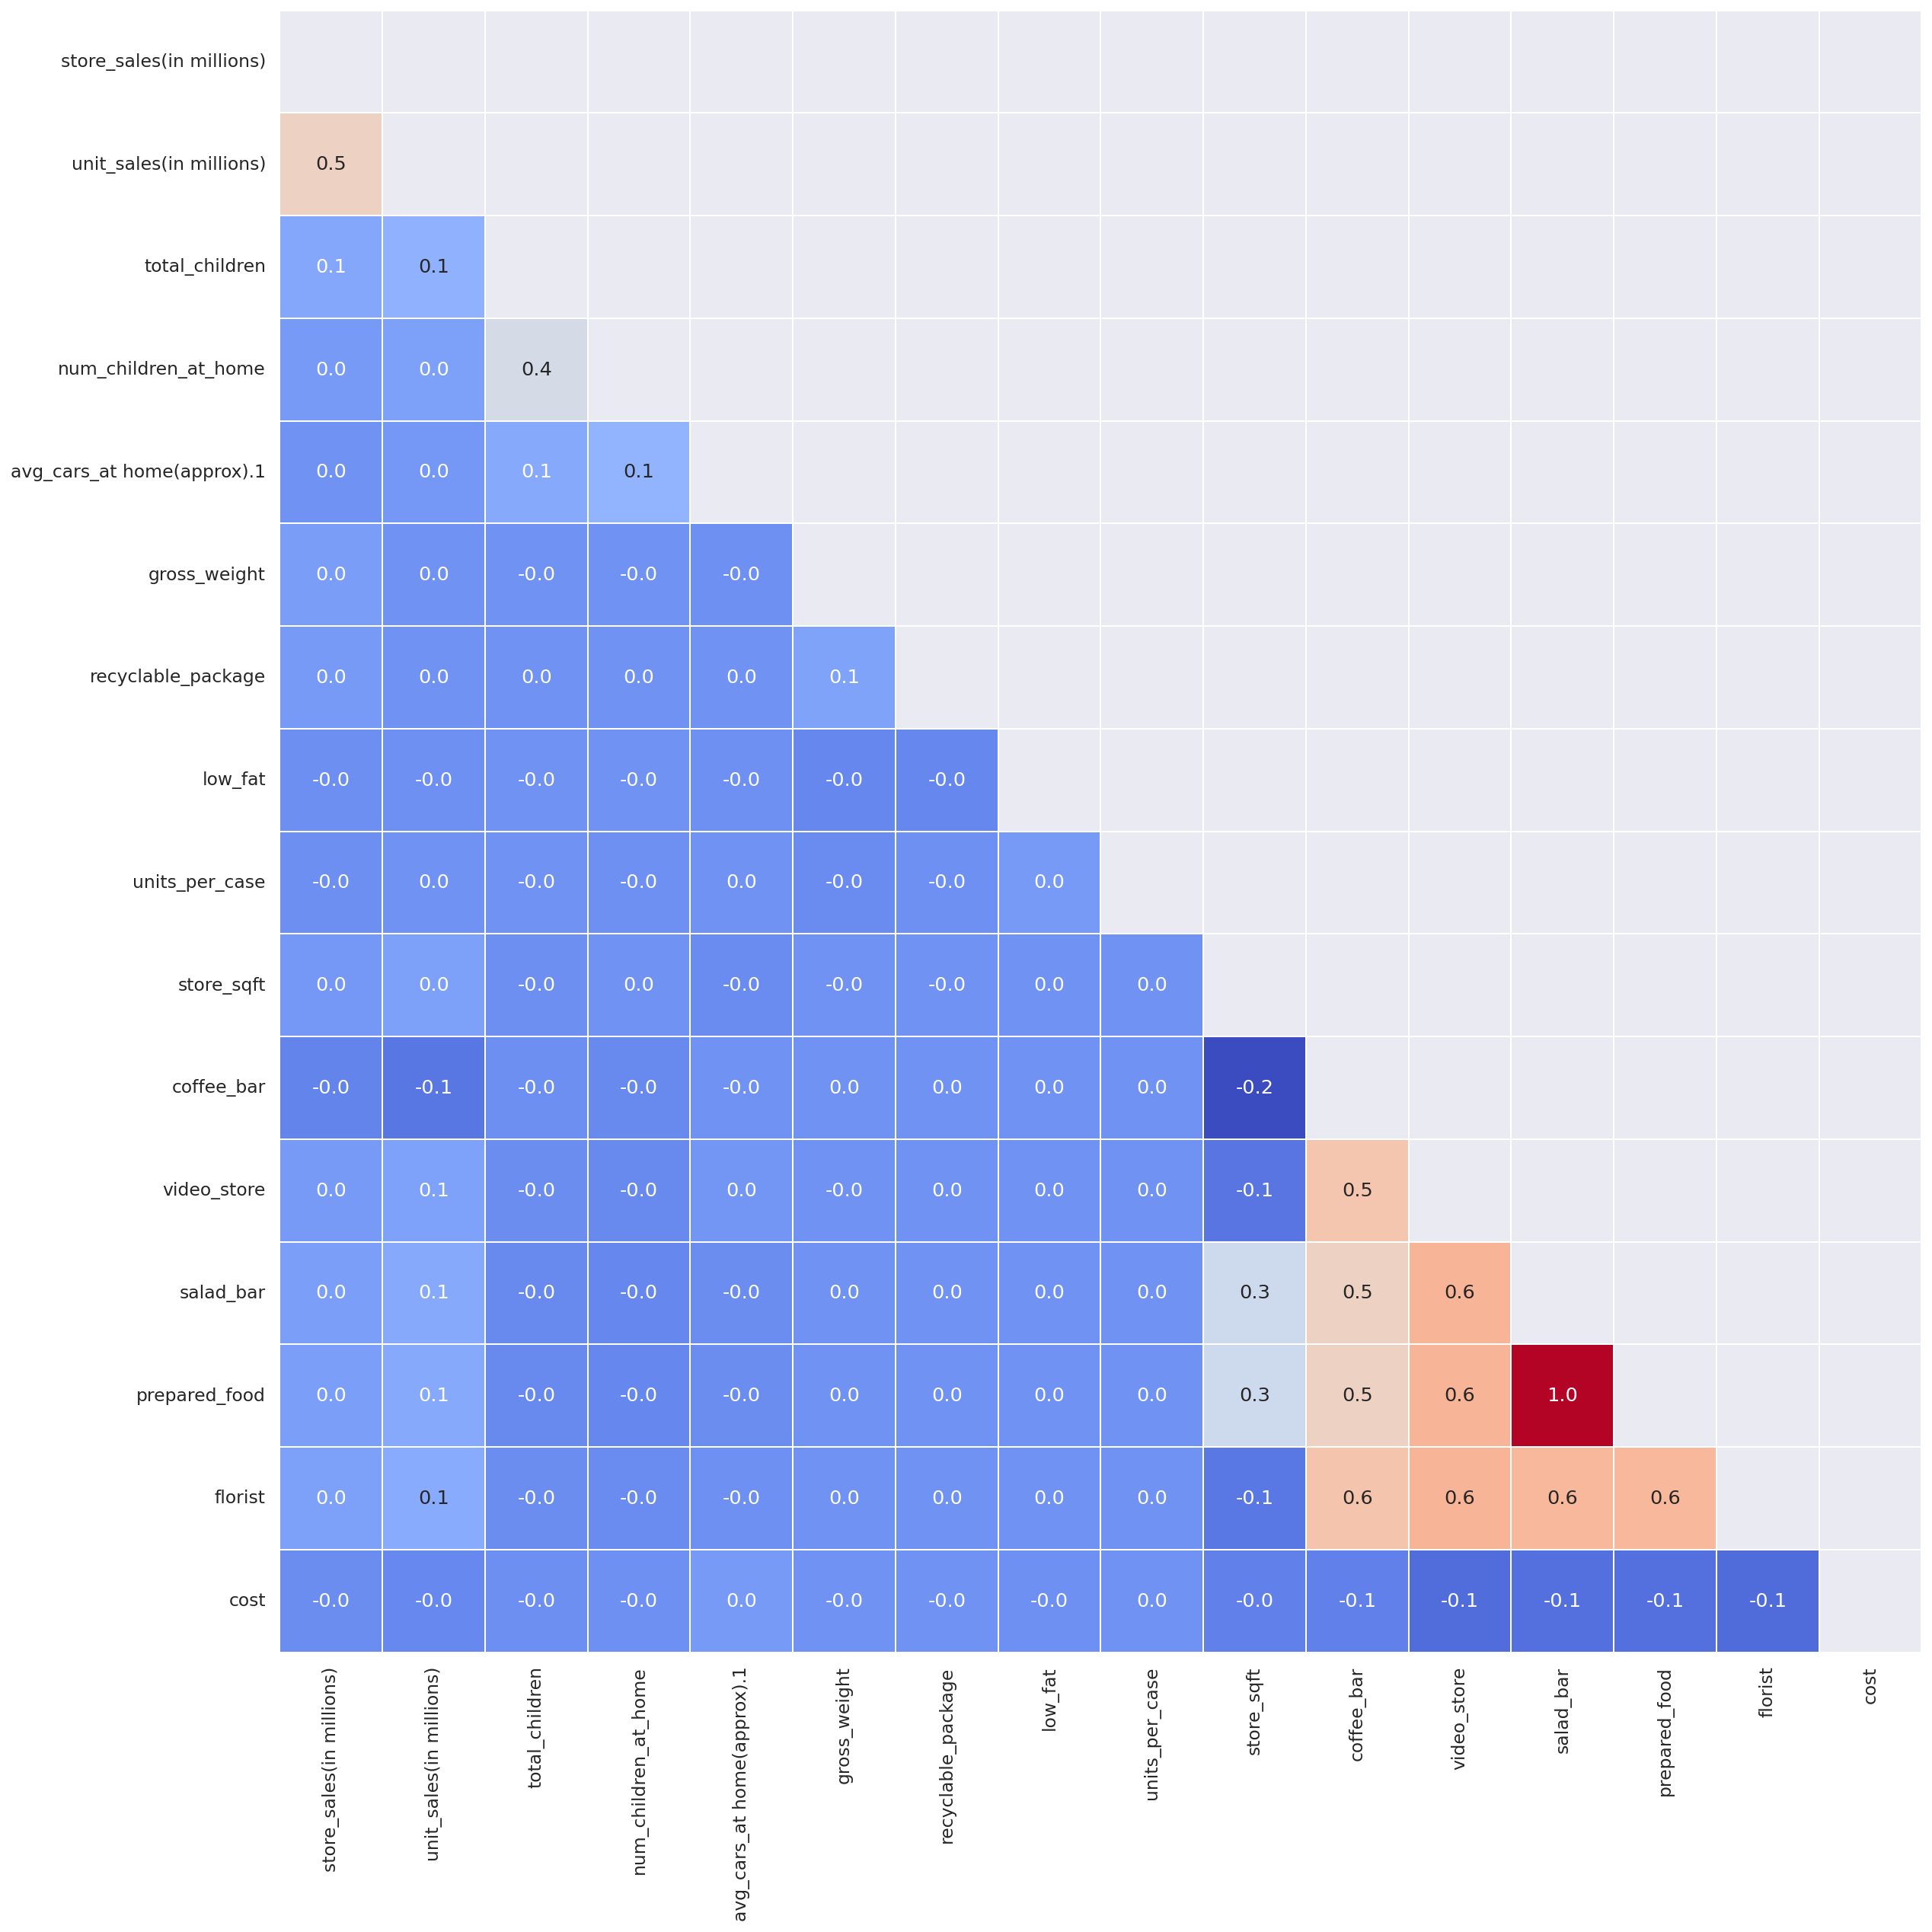

CPU times: user 1.98 s, sys: 308 ms, total: 2.28 s
Wall time: 2.04 s


In [20]:
%%time
num_feats = list(train.select_dtypes(exclude=["object","bool"]))
num_feats.remove("id")

corr = train[num_feats].corr()
mask = np.triu(train[num_feats].corr())

sns.set(font_scale=1.1)
plt.figure(figsize=(20, 20), dpi=140)
sns.heatmap(corr, annot=True, fmt='.1f', 
            cmap='coolwarm', 
            square=True, 
            mask=mask, 
            linewidths=1,
            cbar=False)
plt.show()

### Pair Plot

In [21]:
cont_features

['store_sales(in millions)',
 'unit_sales(in millions)',
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'gross_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist']

In [22]:
# %%time
# plt.figure(figsize=(15,8))

# sns.pairplot(
#     train,
#     vars=[
#         "WorkLifeBalance",
#         "Education",
#         "Age",
#         "YearsAtCompany",
#     ],
#     hue=TARGET,
# )
# plt.show()


## PCA

- https://www.kaggle.com/code/samuelcortinhas/ps-s3e3-hill-climbing-like-a-gm
- https://www.kaggle.com/competitions/playground-series-s3e3/discussion/380313

array([0.23229008, 0.33920968, 0.43163151, 0.51638235, 0.58904477,
       0.65608232, 0.72036992, 0.7839291 , 0.84650705, 0.88895866,
       0.92409271, 0.95260899, 0.97828208, 0.99998927, 1.        ])

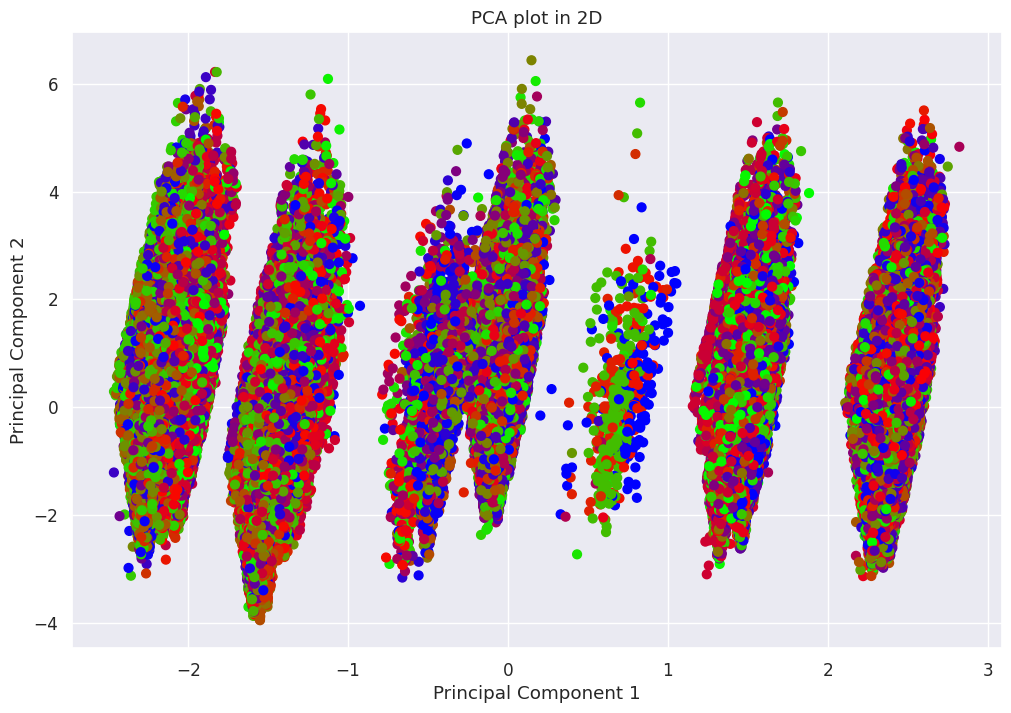

In [23]:
def show_pca(df:pd.DataFrame, target:str) -> None:
    scale = preprocessing.StandardScaler()
    X = scale.fit_transform(df)
    pca = decomposition.PCA()
    X_pca = pca.fit_transform(X)
    pca_df = pd.DataFrame(data = X_pca)

    variance = pd.DataFrame(pca.explained_variance_ratio_)
    display(np.cumsum(pca.explained_variance_ratio_))


    plt.figure(figsize=(12,8))
    plt.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], c=train[target], cmap="brg", s=40)
    plt.title('PCA plot in 2D')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
show_pca(train[cont_features], TARGET)    

In [24]:
# %%time
# if not Config.fast_render:
#     X = train[cont_features].copy()
#     sns.pairplot(data=train[cont_features].drop(columns=[]), height=3, diag_kind="hist", palette=theme_palette)
#     sns.pairplot(train, height=3, diag_kind="hist")
#     plt.show()

## Feature Engineering

### Encode Categorical Features

In [25]:
# https://www.kaggle.com/competitions/playground-series-s3e11/discussion/396533
excluded_features = [TARGET, "id", "fold", 'store_sales', 'gross_weight', 'recyclable_package']

In [26]:
cat_features

[]

In [27]:
#train, test = label_encoder(train, test, cat_features)
# X_test = pd.get_dummies(test[FEATURES], drop_first=True)

train.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.00,2.00,2.00,2.00,10.30,1.00,0.00,32.00,"36,509.00",0.00,0.00,0.00,0.00,0.00,62.09
1,1,5.00,2.00,4.00,0.00,3.00,6.66,1.00,0.00,1.00,"28,206.00",1.00,0.00,0.00,0.00,0.00,121.80
2,2,14.08,4.00,0.00,0.00,3.00,21.30,1.00,0.00,26.00,"21,215.00",1.00,0.00,0.00,0.00,0.00,83.51
3,3,4.02,3.00,5.00,0.00,0.00,14.80,0.00,1.00,36.00,"21,215.00",1.00,0.00,0.00,0.00,0.00,66.78
4,4,2.13,3.00,5.00,0.00,3.00,17.00,1.00,1.00,20.00,"27,694.00",1.00,1.00,1.00,1.00,1.00,111.51


In [28]:
cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

cont_features = [feature for feature in cont_features if feature not in excluded_features]
cat_features = [feature for feature in cat_features if feature not in excluded_features]

FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['id', 'store_sales(in millions)', 'unit_sales(in millions)', 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist', 'cost']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['store_sales(in millions)',
 'unit_sales(in millions)',
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'low_fat',
 'units_per_case',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist']

In [29]:
train = create_folds(train, Config.N_FOLDS)
# train = create_strat_folds(train, TARGET, Config.N_FOLDS)

n_folds=15, seed=42


In [30]:
# lgbm_params01 = {
#     'objective': 'binary',
#      'metric': 'auc',
#      'feature_pre_filter': False,
#      'lambda_l1': 1.9488299167684667e-07,
#      'lambda_l2': 9.456184670156514,
#      'num_leaves': 6,
#      'feature_fraction': 0.8,
#      'bagging_fraction': 0.8065,
#      'bagging_freq': 4,
#      'min_child_samples': 10,
#      'num_iterations': 400,
#      'learning_rate':0.05
# }

lgbm_params = {'n_estimators': Config.N_ESTIMATORS,
                 'num_rounds': 404,
                 'learning_rate': 0.19,
                 'num_leaves': 17,
                 'max_depth': 8,
                 'min_data_in_leaf': 36,
                 'lambda_l1': 0.96,
                 'lambda_l2': 0.01,
                 'min_gain_to_split': 11.32,
                 'bagging_fraction': 0.6,
                 'feature_fraction': 0.9}


lgbm_params01 = {
    "n_estimators": Config.N_ESTIMATORS,
    'max_depth': 9,
    'learning_rate': 0.01,
    'min_data_in_leaf': 36, 
    'num_leaves': 100, 
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.89, 
    'bagging_freq': 5, 
    'lambda_l2': 28,
    
    'seed': Config.seed,
    'objective': 'regression',
#     'boosting_type': 'gbdt',
#     'device': 'gpu', 
#     'gpu_platform_id': 0,
#     'gpu_device_id': 0,
    'n_jobs': -1,
    'metric': 'rmse',
    'verbose': -1
}

if Config.gpu:
    lgbm_params01 = gpu_ify_lgbm(lgbm_params01)


In [31]:
cb_params = {
    #     "learning_rate": 0.3277295792305584,
    "learning_rate": 0.05,
    "l2_leaf_reg": 3.1572972266001518,
    "bagging_temperature": 0.6799604234141348,
    "random_strength": 1.99590400593318,
    "depth": 10,
    "min_data_in_leaf": 93,
    # "iterations": 100,  # 10000
    "n_estimators": Config.N_ESTIMATORS,  # 10000
    "use_best_model": True,
    #     "task_type": "GPU",
    "random_seed": Config.seed,
}

if Config.gpu:
    cb_params = gpu_ify_cb(cb_params)

In [32]:
xgb_params = {
    "n_estimators": Config.N_ESTIMATORS,  # 10_000,
    "max_depth": 10,  # 10
    "objective": "reg:squarederror",
#     "objective": 'reg:squaredlogerror',
    "eval_metric": 'rmsle',
    #     "enable_categorical": True,  # Only works with gpu_hist
    #     "eval_metric": "mae",
    #     "metric": "mae",
    #     "enable_categorical": True,
    "n_jobs": 8,  # 4
    "seed": Config.seed,
    "tree_method": "hist",
    #         "gpu_id": 0,
    "subsample": 0.9,  # 0.7
    "colsample_bytree": 0.7,
    "use_label_encoder": False,
    "learning_rate": 0.05,  # 0.01
}

xgb_params3 = {
    'n_estimators': Config.N_ESTIMATORS,
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror'
}

if Config.gpu:
    xgb_params["tree_method"] = "gpu_hist"
else:
    xgb_params["tree_method"] = "hist"

In [33]:
model_estimator_dict = {
    "lgbm1": lgb.LGBMRegressor(**lgbm_params),
    "cat1": cb.CatBoostRegressor(cb_params),
    "xgb1": xgb.XGBRegressor(**xgb_params),

}

In [34]:
all_cv_scores = pd.DataFrame(
    {
        "Model": pd.Series(dtype="str"),
        "Score": pd.Series(dtype="float"),
        "StdDev": pd.Series(dtype="float"),
        "RunTime": pd.Series(dtype="float"),
    }
)

oof = train[["id", TARGET, "fold"]].copy().reset_index(drop=True).copy()
oof.set_index("id", inplace=True)
oof.head()

,cost,fold
id,,
0,62.09,3
1,121.80,8
2,83.51,1
3,66.78,11
4,111.51,5


In [35]:
def show_tree_model_fi(model, features:List[str]) -> None:
    print("\n=== Model Feature Importance ===")
    for i in model.feature_importances_.argsort()[::-1]:
        print(features[i], model.feature_importances_[i]/model.feature_importances_.sum())

def save_oof_predictions(model_name:str, final_valid_predictions, oof:pd.DataFrame) -> pd.DataFrame:
    final_valid_predictions_df = process_valid_predictions(
        final_valid_predictions, "id", model_name
    )
    display(final_valid_predictions_df.head())
    oof[f"pred_{model_name}"] = final_valid_predictions_df[f"pred_{model_name}"]

    return oof

def save_test_predictions(model_name:str, final_test_predictions, submission_df:pd.DataFrame, result_field:str=TARGET) -> None:
    result = merge_test_predictions(final_test_predictions, Config.calc_probability)
    # result[:20]
    submission_df[f"target_{model_name}"] = result
    #     submission_df.head(10)
    ss = submission_df[["id", f"target_{model_name}"]].copy().reset_index(drop=True)
    ss.rename(columns={f"target_{model_name}": result_field}, inplace=True)
    ss.to_csv(
        f"submission_{model_name}.csv", index=False
    )  # Can submit the individual model
    ss.head(10)

def process_valid_predictions(final_valid_predictions, train_id, model_name:str) -> pd.DataFrame:
    model = f"pred_{model_name}"
    final_valid_predictions_df = pd.DataFrame.from_dict(
        final_valid_predictions, orient="index"
    ).reset_index()
    final_valid_predictions_df.columns = [train_id, model]
    final_valid_predictions_df.set_index(train_id, inplace=True)
    final_valid_predictions_df.sort_index(inplace=True)
    final_valid_predictions_df.to_csv(f"train_pred_{model_name}.csv", index=True)

    return final_valid_predictions_df

def add_score(score_df:pd.DataFrame, model_name:str, score:float, std:float):
    dict1 = {"Model": model_name, "Score": cv_score, "StdDev": std_dev}
    score_df = score_df.append(dict1, ignore_index=True)
    return score_df

In [36]:
def train_xgb_model(
    df:pd.DataFrame,
    test:pd.DataFrame,
    get_model_fn,
    FEATURES:List[str],
    TARGET:str,
    calc_probability:bool,
    rowid:str,
    params,
    n_folds:int=5,
    seed:int=42,
):

    print(params)
    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = xvalid.id.values.tolist()  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        model = get_model_fn # (params)

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            #             eval_metric="acc",  # auc
            verbose=False,
            #             early_stopping_rounds=3000,
            #             callbacks=[
            #                 xgb.log_evaluation(0),
            #                 xgb.early_stopping(500, False, True),
            #             ],
        )

        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)
        
        final_test_predictions.append(test_preds)
        if Config.debug:
            print(f"GT Type: {type(yvalid.values)}")
            print(f"Preds Type: {type(preds_valid_class)}")
            print(f"         GT:{yvalid.values[:20]}")
            print(f"Preds Class:{preds_valid_class[:20]}")
            print(f"Preds Prob:{preds_valid[:20]}")
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid_class)))

#         fold_score = metrics.roc_auc_score(yvalid.values, preds_valid)  # Validation Set Score
#         fold_score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        fold_score = metrics.mean_squared_log_error(yvalid, preds_valid, squared=False)

     
#         show_classification_scores(yvalid.values, preds_valid_class)
#         fold_score = metrics.mean_absolute_error(
#             yvalid, preds_valid
#         )  # Validation Set Score
#         fold_score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )        

In [37]:
def run_tree_model(model_dict, model_name:str, features:List[str], params, oof:pd.DataFrame) -> (float, float, pd.DataFrame):
    (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    ) = train_xgb_model(
        train,
        test,
        model_dict[model_name],
        features,
        TARGET,
        Config.calc_probability,
        "id",
        params,
        Config.N_FOLDS,
        Config.seed,
    )

    cv_score, std_dev = show_fold_scores(fold_scores)
    show_tree_model_fi(model, features)
    show_feature_importance(feature_importance_lst)
    
    oof = save_oof_predictions(model_name, final_valid_predictions, oof)
    oof.head()
    save_test_predictions(model_name, final_test_predictions, sample_submission, TARGET)

    return cv_score, std_dev, oof

In [38]:
%%time

def run_models4features(model_dict, model_lst:List[str], target:str, feature_lst:List[str], all_cv_scores:pd.DataFrame, linear_models:bool=True) -> pd.DataFrame:

    oof = train[["id", target, "fold"]].copy().reset_index(drop=True).copy()
    oof.set_index("id", inplace=True)

    for idx, m in enumerate(model_lst):
        model = model_lst[idx]
        start_time = time.time()

        print(f"Model={model}")

        params = {}
        if linear_models:
                cv_score, std_dev, oof = run_linear_model(model_dict, model, feature_lst, oof)

        else:
            cv_score, std_dev, oof = run_tree_model(model_dict, model, feature_lst, params, oof)

        run_time = time.time() - start_time

        score_dict = {"Model": model, "Score": cv_score, "StdDev": std_dev, "RunTime": run_time}
        all_cv_scores = all_cv_scores.append(score_dict, ignore_index=True)
        print(f"Model Run Time: {run_time:.2f}")

    return all_cv_scores

CPU times: user 25 µs, sys: 2 µs, total: 27 µs
Wall time: 32.4 µs


## Tree Models

Model=xgb1
{}
========== Fold 1/15 ==========
fold: 1, Score: 0.3050364129548982, Run Time: 73.46
========== Fold 2/15 ==========
fold: 2, Score: 0.30456663079739604, Run Time: 74.56
========== Fold 3/15 ==========
fold: 3, Score: 0.3014575571958868, Run Time: 73.15
========== Fold 4/15 ==========
fold: 4, Score: 0.3022878588059071, Run Time: 73.40
========== Fold 5/15 ==========
fold: 5, Score: 0.30302322406628573, Run Time: 72.36
========== Fold 6/15 ==========
fold: 6, Score: 0.30159831437617957, Run Time: 72.44
========== Fold 7/15 ==========
fold: 7, Score: 0.30256103320499456, Run Time: 73.59
========== Fold 8/15 ==========
fold: 8, Score: 0.3044437807792557, Run Time: 72.86
========== Fold 9/15 ==========
fold: 9, Score: 0.3021482376512024, Run Time: 73.71
========== Fold 10/15 ==========
fold: 10, Score: 0.30603803082766523, Run Time: 72.89
========== Fold 11/15 ==========
fold: 11, Score: 0.30359611038416184, Run Time: 73.32
========== Fold 12/15 ==========
fold: 12, Score: 0.

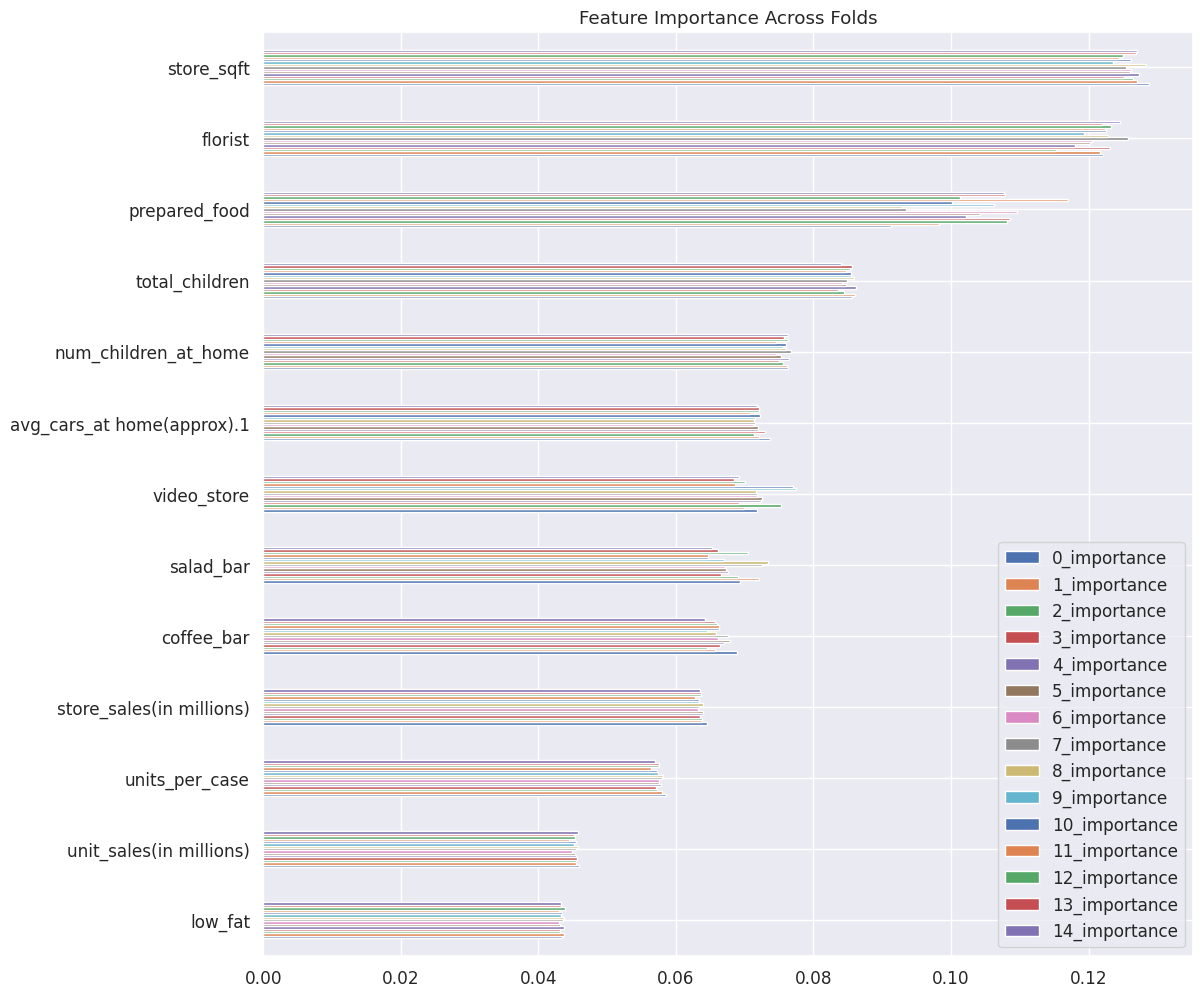

,pred_xgb1
id,
0,102.53
1,106.76
2,120.17
3,123.42
4,89.24


Mode
Model Run Time: 1110.47
CPU times: user 43min 29s, sys: 1min 25s, total: 44min 55s
Wall time: 18min 30s


In [39]:
%%time
# model_lst = ["xgb1", "lgbm2", "lgbm1", "cat1"]
# model_lst = ["lgbm1", "xgb1"]
model_lst = ["xgb1"]
all_cv_scores = run_models4features(model_estimator_dict, model_lst, TARGET, FEATURES, all_cv_scores, linear_models=False)    

In [40]:
pd.options.display.max_colwidth = 100
pd.set_option("display.max_rows", 999)
pd.set_option("display.precision", 5)
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_colwidth

100

In [41]:
all_cv_scores.sort_values(by=["Score"], ascending=False)

,Model,Score,StdDev,RunTime
0,xgb1,0.30342,0.00150,1110.46917
